In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
node_type = 'compute_haswell'
interval = 24

# Step 1. Preprocess Machine Events

In [3]:
ucme = pd.read_csv('datasets/uc_machine_events.csv')
taccme = pd.read_csv('datasets/tacc_machine_events.csv')
ucme['EVENT_TIME'] = pd.to_datetime(ucme['EVENT_TIME'])
taccme['EVENT_TIME'] = pd.to_datetime(taccme['EVENT_TIME'])
ucme.sort_values(by=['EVENT_TIME'], inplace=True)
taccme.sort_values(by=['EVENT_TIME'], inplace=True)

In [4]:
m = ucme.iloc[-1]['HOST_NAME (PHYSICAL)']
ucme[ucme['HOST_NAME (PHYSICAL)'] == m].to_csv('temp.csv', index=None)

In [5]:
def set_machine_type(df):
    node_types = []
    for index, row in df.iterrows():
        try:
            nt = row['PROPERTIES']
            nt = nt.replace('\'', '\"')
            nt = nt.replace('None', '\"None\"')
            if 'node_type' in nt:
                nt = json.loads(nt)['node_type']
            else:
                nt = None
        except:
            nt = None
        node_types.append(nt)
    df['node_type'] = node_types
    return df

ucme = set_machine_type(ucme)
taccme = set_machine_type(taccme)

In [6]:
# select haswell only
ucme = ucme[ucme['node_type']==node_type]
taccme = taccme[taccme['node_type']==node_type]

In [7]:
ucme_start_date = ucme.iloc[0]['EVENT_TIME']
ucme_end_date = ucme.iloc[-1]['EVENT_TIME']
taccme_start_date = taccme.iloc[0]['EVENT_TIME']
taccme_end_date = taccme.iloc[-1]['EVENT_TIME']

# Step 2. Preprocess Lease Info Data

In [8]:
litacc = pd.read_csv('datasets/lease_info_tacc.csv')
liuc = pd.read_csv('datasets/lease_info_uc.csv')

In [9]:
def process_lease_data(df):
    df['start_on'] = pd.to_datetime(df['start_on'])
    df['deleted_at'] = pd.to_datetime(df['deleted_at'])
    df['end_on'] = pd.to_datetime(df['end_on'])
    for i in df.index:
        deleted_at = df.iloc[i]['deleted_at']
        end_on = df.iloc[i]['end_on']
        if deleted_at and deleted_at < end_on:
            df.at[i, 'end_on'] = deleted_at  # set the end_on time to smaller(end_on, deleted_at) since users may delete the lease before ending
    df.sort_values(by=['start_on'], inplace=True)
    return df
    
litacc = process_lease_data(litacc)
liuc = process_lease_data(liuc)
filter_by_date = lambda df, start, end: df[(df['start_on'] >= start) & (df['start_on'] <= end)] 
litacc = filter_by_date(litacc, taccme_start_date, taccme_end_date)
liuc = filter_by_date(liuc, ucme_start_date, ucme_end_date)

In [10]:
from ast import literal_eval

def filter_node_type(df):
    node_types = list(set([literal_eval(nt)[2] for nt in df['reserve_conditions'].dropna() if '$node_type' in literal_eval(nt)]))
    assign_nt = []
    select_leases = []
    for index, row in df.iterrows():
        if row['reserve_conditions'] is not np.nan:
            if '$node_type' in literal_eval(row['reserve_conditions']) and literal_eval(row['reserve_conditions'])[0] in ['=', '==']:
                assign_nt.append(literal_eval(row['reserve_conditions'])[2])
                select_leases.append(row['lease_id'])
    df = df[df['lease_id'].isin(select_leases)]
    df['node_type'] = assign_nt
    df = df[df['node_type'] == node_type]
    return df

litacc = filter_node_type(litacc)
liuc = filter_node_type(liuc)
litacc.sort_values(by=['start_on'], inplace=True)
liuc.sort_values(by=['start_on'], inplace=True)

# Step 3. Trace In-use and Available Resources

In [11]:
def trace_in_use(df, slot):
    tracer = []
    df = df[~df['status'].isin(['error', 'pending'])]
    for index, row in df.iterrows():
        if row['start_on'] < row['end_on']:  # no resource is allocated if the lease end time is earlier than the start time
            tracer.append({
                'timestamp': row['start_on'],
                'in_use': row['node_cnt']
            })
            tracer.append({
                'timestamp': row['end_on'],
                'in_use': -row['node_cnt']
            })

    tracer = pd.DataFrame(tracer)
    tracer.sort_values(by=['timestamp'], inplace=True)
    tracer['in_use'] = np.cumsum(tracer['in_use'].to_list())
    tracer.set_index(['timestamp'], inplace=True)
    tracer = tracer.resample('%dH' % slot).max().fillna(0)
    return tracer

litacc_tracer = trace_in_use(litacc, interval)
liuc_tracer = trace_in_use(liuc, interval)

In [12]:
def trace_av(df, slot):
    tracer = []
    unique_host = {}
    for index, row in df.iterrows():
        ## ???? UPDATE执行的是什么操作，是否自动enable节点
        if row['EVENT'] in ['ENABLE', 'UPDATE'] and row['HOST_NAME (PHYSICAL)'] not in unique_host:
            unique_host.update({row['HOST_NAME (PHYSICAL)']: row['EVENT']})
            tracer.append({
                'timestamp': row['EVENT_TIME'],
                'available': 1
            })
        elif row['EVENT'] in ['DISABLE'] and row['HOST_NAME (PHYSICAL)'] in unique_host:
            del unique_host[row['HOST_NAME (PHYSICAL)']]
            tracer.append({
                'timestamp': row['EVENT_TIME'],
                'available': -1
            })

    tracer = pd.DataFrame(tracer)
    tracer.sort_values(by=['timestamp'], inplace=True)
    tracer['available'] = np.cumsum(tracer['available'].to_list())
    tracer.set_index(['timestamp'], inplace=True)
    tracer = tracer.resample('%dH' % slot).max().fillna(method='ffill')
    return tracer

taccme_tracer = trace_av(taccme, interval)
ucme_tracer = trace_av(ucme, interval)

In [13]:
tacc_tracer = taccme_tracer.join(litacc_tracer)
uc_tracer = ucme_tracer.join(liuc_tracer)

In [14]:
def plot_trace(data, fields):
    fig = go.Figure()
    for f in fields:
        fig.add_trace(go.Scatter(x=data.index, y=data[f], mode='lines', name=f))
    fig.update_layout(showlegend=True)

    fig.update_layout(
        width=1000,
        height=500,
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="LightSteelBlue",
    )
    fig.show()

In [15]:
plot_trace(tacc_tracer, ['available', 'in_use'])

In [16]:
plot_trace(uc_tracer, ['available', 'in_use'])

In [17]:
tacc_tracer['rate'] = tacc_tracer['in_use']/tacc_tracer['available']
uc_tracer['rate'] = uc_tracer['in_use']/uc_tracer['available']

In [18]:
print('Mean:', tacc_tracer['rate'].mean())
print('Std:', tacc_tracer['rate'].std())
print('Percentile:', tacc_tracer['rate'].quantile([0.5, 0.8, 0.9, 0.95]))

Mean: 0.6848935687871179
Std: 0.1904679471411409
Percentile: 0.50    0.687805
0.80    0.858025
0.90    0.933333
0.95    0.980058
Name: rate, dtype: float64


In [19]:
print('Mean:', uc_tracer['rate'].mean())
print('Std:', uc_tracer['rate'].std())
print('Percentile:', uc_tracer['rate'].quantile([0.5, 0.8, 0.9, 0.95]))

Mean: 0.4942508240310085
Std: 0.2642038106898611
Percentile: 0.50    0.450000
0.80    0.780488
0.90    0.888056
0.95    0.950123
Name: rate, dtype: float64


<AxesSubplot:>

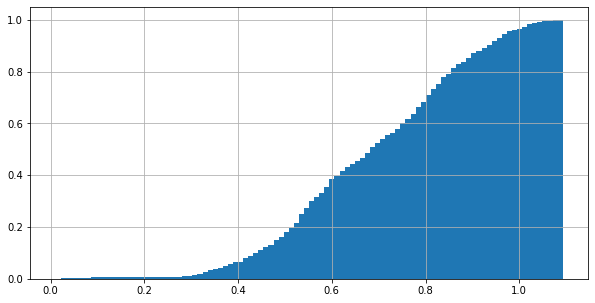

In [20]:
tacc_tracer['rate'].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))

<AxesSubplot:>

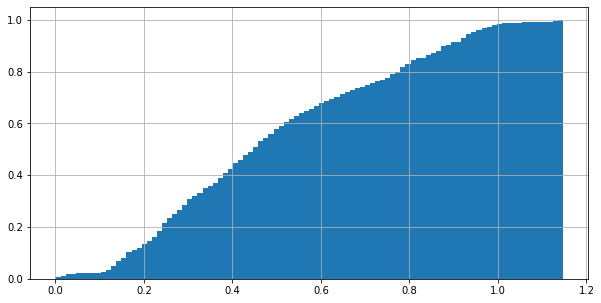

In [21]:
uc_tracer['rate'].hist(bins=100, cumulative=True, density=1, figsize=(10, 5))